In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
bio = pd.read_csv("../dataset/Agriculture_biologique_final.csv", sep ="\t")
env = pd.read_csv("../dataset/Impact environnemental_final.csv", sep="\t",low_memory=False)
qual = pd.read_csv("../dataset/Qualite nutritionnelle_final.csv", sep="\t",low_memory=False)

# 0  Nettoyage

## 0.1 Regroupement des datasets

Colonnes communes env & qual

In [3]:
env.columns[env.columns.isin(qual.columns)]

Index(['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags',
       'serving_size', 'image_url'],
      dtype='object')

Merge des df env et qual

In [4]:
envqual = env.merge(qual, on = ['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags','serving_size', 'image_url'], how='outer', indicator='merged_qual')
envqual.columns

Index(['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags',
       'serving_size', 'image_url', 'ecoscore_grade', 'est_plastique',
       'est_palm', 'est_cocoa', 'ingredients_tags', 'nutriscore_grade',
       'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'nb_nocif', 'merged_qual'],
      dtype='object')

Colonnes communes envqual et bio

In [5]:
envqual.columns[envqual.columns.isin(bio.columns)]

Index(['product_name', 'brands_tags', 'serving_size'], dtype='object')

Merge des df env et qual

In [6]:
envqualbio = envqual.merge(bio, on=['product_name', 'brands_tags', 'serving_size'], how='outer', indicator='merged_bio')
envqualbio.columns

Index(['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags',
       'serving_size', 'image_url', 'ecoscore_grade', 'est_plastique',
       'est_palm', 'est_cocoa', 'ingredients_tags', 'nutriscore_grade',
       'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g',
       'proteins_100g', 'salt_100g', 'nb_nocif', 'merged_qual', 'est_bio',
       'merged_bio'],
      dtype='object')

On supprime les doublons

In [7]:
envqualbio = envqualbio.drop_duplicates()
envqualbio.duplicated().sum()

0

In [8]:
envqualbio.reset_index(inplace=True)

In [9]:
envqualbio.drop(columns='index',inplace=True)

Gestion des valeurs manquantes

Pourcentage des valeurs manquantes par colonnes

In [10]:
envqualbio.isnull().sum()

code                       0
product_name           24354
quantity              579572
brands_tags           412045
countries_tags             0
serving_size          763369
image_url              71750
ecoscore_grade           662
est_plastique              0
est_palm                   0
est_cocoa                  0
ingredients_tags      596585
nutriscore_grade      543571
energy-kcal_100g      215440
fat_100g              197506
saturated-fat_100g    192288
sugars_100g           192913
proteins_100g         195686
salt_100g             222287
nb_nocif                   0
merged_qual                0
est_bio               412045
merged_bio                 0
dtype: int64

In [13]:
envqualbio.shape

(849616, 23)

 Pourcentage de données nulles du tableau

In [14]:
envqualbio.isnull().sum() / envqualbio.shape[0] * 100

code                   0.000000
product_name           2.866471
quantity              68.215759
brands_tags           48.497792
countries_tags         0.000000
serving_size          89.848708
image_url              8.444992
ecoscore_grade         0.077918
est_plastique          0.000000
est_palm               0.000000
est_cocoa              0.000000
ingredients_tags      70.218193
nutriscore_grade      63.978433
energy-kcal_100g      25.357338
fat_100g              23.246502
saturated-fat_100g    22.632342
sugars_100g           22.705905
proteins_100g         23.032288
salt_100g             26.163231
nb_nocif               0.000000
merged_qual            0.000000
est_bio               48.497792
merged_bio             0.000000
dtype: float64

# Quelles sont les marques qui jouent le jeu et affichent le nutriscore ? Lesquelles ne le font pas?

In [12]:
ind_brand_missing = envqualbio.loc[envqualbio.brands_tags.isnull()].index
df_Wmarques= envqualbio.drop(index=ind_brand_missing)

# Quelles sont les marques qui ont le plus recours aux additifs nocifs ?

In [13]:
df_Wmarques.nb_nocif.unique()

array([0., 1.])

Les 10 marques ayant le plus recours aux produits nocifs

In [14]:
df_Wmarques.groupby('brands_tags').nb_nocif.sum().sort_values(ascending= False)[:10]

brands_tags
sodastream          29.0
nestle,sveltesse    10.0
a-rom                9.0
dove                 8.0
nestle               7.0
schweppes            7.0
freeway              6.0
eco                  4.0
fruiss               4.0
steff                4.0
Name: nb_nocif, dtype: float64

# Quelles sont les marques qui jouent le jeu et affichent l'ecoscore ? Lesquelles ne le font pas?

## Définition d'un seuil de nombre de produit par marque

In [15]:
seuil = 5
marques_p = (df_Wmarques.groupby('brands_tags').product_name.count() > seuil).index
df_gdemarq = df_Wmarques[df_Wmarques.brands_tags.isin(marques_p)]

## Marques présentant le plus de produits avec un ecoscore inconnu ou null

In [16]:
count_nut_miss = df_gdemarq.brands_tags.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull()) ].value_counts()
count_nut_miss

brands_tags
carrefour                                 5819
auchan                                    4316
u                                         2215
nestle                                    2028
casino                                    1874
                                          ... 
la-p-tite-fabrique-des-alpes                 1
foie-gras-de-canard                          1
les-3-terres,domaine-caroline-bonnefoy       1
e-p-f                                        1
vitaflor,milical                             1
Name: count, Length: 35956, dtype: int64

Ratio pour d'ecoscore absent pour les 10 marques présentants le plus de produits sans ecoscore

<Axes: xlabel='count', ylabel='count'>

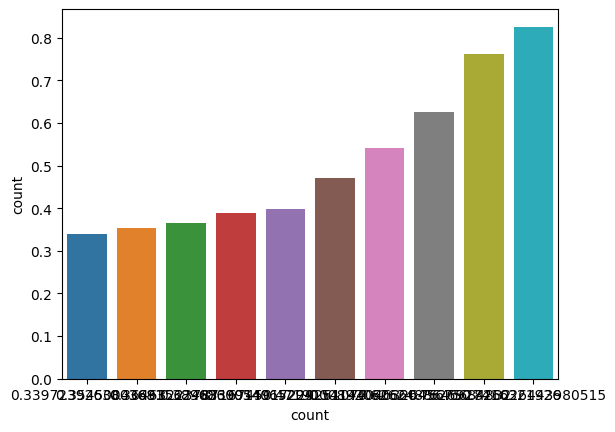

In [19]:
ratio_eco_brand = count_nut_miss[:10] / df_gdemarq.brands_tags[df_gdemarq.brands_tags.isin(count_nut_miss[:10].index)].value_counts()
sns.barplot(ratio_eco_brand.sort_values(ascending=False)[:10],x=ratio_eco_brand.sort_values(ascending=False).index[:10], y=ratio_eco_brand.sort_values(ascending=False)[:10])

## Marques qui utilisent le plus d'ecoscore

In [20]:
df_gdemarq.ecoscore_grade.unique()

array(['d', 'unknown', 'c', 'b', 'not-applicable', 'a', 'e', nan],
      dtype=object)

In [21]:
count_nut_W = df_gdemarq.brands_tags.loc[df_gdemarq.ecoscore_grade.isin(['d','c', 'b', 'not-applicable', 'a', 'e'])].value_counts()
count_nut_W

brands_tags
carrefour                             6512
auchan                                6497
u                                     4305
casino                                2935
leader-price                          2842
                                      ... 
zielinger                                1
collin-bourrisset                        1
collin-bourisset                         1
signe-vignerons,chateau-de-la-prat       1
taf                                      1
Name: count, Length: 34727, dtype: int64

In [22]:
ratio_eco_good = count_nut_W[:10] / df_gdemarq.brands_tags[df_gdemarq.brands_tags.isin(count_nut_W[:10].index)].value_counts()
ratio_eco_good.sort_values(ascending=False)

brands_tags
belle-france    0.827442
franprix        0.715640
le-gaulois      0.696796
u               0.660276
cora            0.645500
leader-price    0.635368
monoprix        0.626266
casino          0.610314
auchan          0.600851
carrefour       0.528100
Name: count, dtype: float64

# Quelles sont les marques qui semblent le plus respectueuses de l'environnement ? le moins?

In [23]:
col_indicatrice= ['brands_tags','est_plastique','ecoscore_grade','est_palm','est_cocoa']
df_env_indic = df_gdemarq[col_indicatrice]
df_env_indic.head()

,brands_tags,est_plastique,ecoscore_grade,est_palm,est_cocoa
0,danone,False,d,False,False
1,danone,True,unknown,False,False
2,danone,False,d,False,False
3,danone,False,unknown,False,False
4,danone,False,unknown,False,False


On peut penser à Ordinal Encoder l'ecoscore ?

In [25]:
ind_notapp = df_env_indic.loc[df_env_indic.ecoscore_grade == 'not-applicable'].index
df_env_indic = df_env_indic.drop(index = ind_notapp)

In [26]:
def ord_eco(x):
    if x == 'a':
        return 0
    elif x == 'b':
        return 0.5
    elif x == 'c':
        return 1
    elif x == 'd':
        return 1.5
    else:
        return 2
df_env_indic["eco_ord"] = df_env_indic.ecoscore_grade.map(ord_eco)

In [27]:
df_env_indic["score_env"] = df_env_indic.eco_ord + df_env_indic.est_plastique + df_env_indic.est_palm + df_env_indic.est_cocoa
df_env_indic.groupby("brands_tags").score_env.mean().sort_values(ascending=False).head(10)

brands_tags
ferrero,nutella,ferrero-nutella,ferrero-nutella-ferrero-nutella,ferrero-nutella-ferrero-nutella-ferrero-nutella-ferrero-nutella    5.0
nature-et-decouvertes,nature-decouvertes,dolfin                                                                                    5.0
kinder,ferrero,ferrero-france                                                                                                      5.0
kinder,ferrero,schoko-bons                                                                                                         5.0
bon-bon-buddies,universal                                                                                                          5.0
terry-s,mondelez                                                                                                                   5.0
alwadi                                                                                                                             5.0
gdb                                        

On peut le comparer à la moyenne qui est de : 1.6972031376039614 points

In [28]:
df_env_indic.brands_tags.loc[df_env_indic.score_env == 0 ].count()

12324

12 324 marques ont une moyene de score environnmental de 0. 

In [29]:
df_env_indic.groupby("brands_tags").score_env.mean().sort_values(ascending=True).head(5)

brands_tags
romabella                           0.0
polli-1872-arte-italiana            0.0
solaya,paquito                      0.0
ferme-ferolles,ferme-de-ferolles    0.0
nestle,lipton                       0.0
Name: score_env, dtype: float64

# Observe-t-on une corrélation entre la la qualité nutritionnelle et l'aspect envionnemental ?

In [30]:
df_corr_qualenv = envqualbio[['nutriscore_grade','ecoscore_grade']]

In [39]:
df_corr_qualenv.dropna(axis=0, inplace=True)

/tmp/ipykernel_5036/1263057802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr_qualenv.dropna(axis=0, inplace=True)


In [40]:
df_corr_qualenv.isnull().sum()

nutriscore_grade    0
ecoscore_grade      0
dtype: int64

On effectue un test de Chi-2

In [43]:
from scipy.stats import chi2_contingency as chi2_contingency

def chi2(X,Y,df,graph=False,contengency=True):
    cont_1 = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    if contengency:
        print(cont_1)
    tx = cont_1.loc[:,["Total"]]
    ty = cont_1.loc[["Total"],:]
    n = len(df)
    indep = round(tx.dot(ty) / n)
    chi2, p, dof, expected_freq = chi2_contingency(cont_1)
    ## modifier pour chopper le graph 
    if graph:
        c = cont_1.fillna(0) # On remplace les valeurs nulles par 0
        measure = (c-indep)**2/indep
        xi_n = measure.sum().sum()
        table = measure/xi_n
        sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
        plt.title('Matrice de corrélation')
        plt.show()
    else:
        return chi2, p 

ecoscore_grade       a      b      c      d      e  not-applicable  unknown   
nutriscore_grade                                                              
a                 3893  13548   4350   4716   3583            1969    11755  \
b                 2057   8102   4695   6897   5211             691    12535   
c                 2189  13158  10863  15421   7037             347    17750   
d                 1450  14597  15104  23896  17319             477    22256   
e                  231   3718   7137  13653  15405            1446    18575   
Total             9820  53123  42149  64583  48555            4930    82871   

ecoscore_grade     Total  
nutriscore_grade          
a                  43814  
b                  40188  
c                  66765  
d                  95099  
e                  60165  
Total             306031  


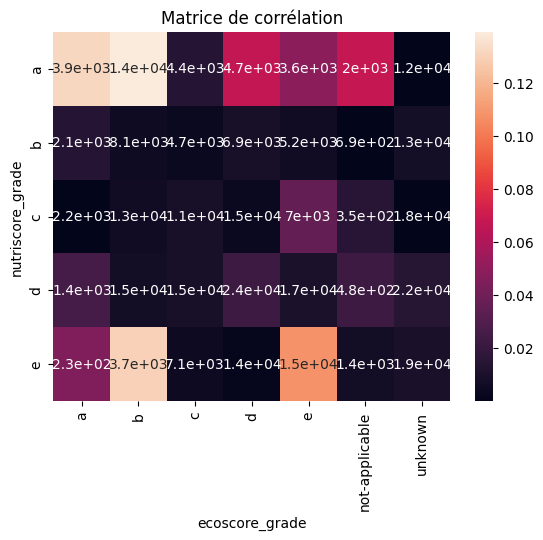

In [46]:
chi2('nutriscore_grade','ecoscore_grade',df_corr_qualenv,graph=True)